In [1]:
%load_ext autoreload
%autoreload 2

import cesium
import numpy as np
import scipy
import pandas as pd
import warnings
import tarfile
import os
import time
import shutil
import joblib
from collections import defaultdict
from random import shuffle
import matplotlib.pyplot as plt
from supersmoother import SuperSmoother
from sklearn.model_selection import train_test_split
from cesium.predict import model_predictions
from cesium.data_management import parse_and_store_ts_data
from cesium.featureset import from_netcdf
from cesium.build_model import build_model_from_featureset
from cesium.features import GENERAL_FEATS, LOMB_SCARGLE_FEATS
from cesium.featurize import featurize_ts_files

import seaborn as sns; sns.set()
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Parse and store TS data
def parse_ts_data_return_paths(tarball_path, header_path=None):
    # header_path = 'data/survey_lcs.header.dat'

    try:
        shutil.rmtree('/tmp/noisification_ts_data')
    except FileNotFoundError:
        pass
    os.mkdir('/tmp/noisification_ts_data')

    start_time = time.time()

    ts_paths = parse_and_store_ts_data(
        data_path=tarball_path, output_dir='/tmp/noisification_ts_data',
        cleanup_archive=False, header_path=header_path, cleanup_header=False)

    print('Parsed & stored', len(ts_paths), 'light curves in',
          '{} minutes'.format(round((time.time() - start_time)/60, 2)))

    return ts_paths

In [3]:
# Generate features (just frequencies here)
def generate_features(ts_paths):
    start_time = time.time()

    featureset = featurize_ts_files(
        ts_paths, features_to_use=['freq1_freq'],
        output_path=None)

    print("Featurized {} light curves in {} minutes.".format(len(ts_paths),
                                                             round((time.time() - start_time)/60., 2)))
    return featureset

In [4]:
def plot_data_4x4(t, m, e, period, target_t, noisified_m, target_e, plot_title=None):
    fig, ax = plt.subplots(2, 2)
    fig.subplots_adjust(hspace=0.25)
    fig.suptitle(plot_title, fontsize=14, fontweight='bold')

    # Original ASAS LC
    t_folded = t % period

    # Plot original ASAS data
    ax[0][0].errorbar(t, m, e, fmt='.')
    ax[0][0].set_xlabel('t')
    ax[0][0].set_title('Original ASAS LC')

    # Plot period-folded ASAS data
    ax[1][0].errorbar(t_folded, m, e, fmt='.')
    ax[1][0].set_xlabel('t')
    ax[1][0].set_title('Original ASAS LC - Period-folded')

    # Generate smoothed curves for the above
    t_smooth = np.linspace(np.min(t), np.max(t), 1000)
    t_smooth_folded = np.linspace(0, period, 1000)
    m_fit = SuperSmoother(period=period).fit(t, m, e).predict(t_smooth)
    m_fit_folded = SuperSmoother(period=period).fit(t_folded, m, e).predict(t_smooth_folded)

    # Plot smoothed curves over ASAS data
    ax[0][0].plot(t_smooth, m_fit, '-k', lw=1)
    ax[1][0].plot(t_smooth_folded, m_fit_folded, '-k', lw=1)

    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    # Target survey LC
    target_t_folded = target_t % period

    # Plot noisified target survey LC data
    print('target_t head and tail:', target_t[:3], target_t[-3:])
    ax[0][1].errorbar(target_t, noisified_m, target_e, fmt='.')
    ax[0][1].set_xlabel('t')
    ax[0][1].set_title('LC noisified to target survey')

    # Plot period-folded target survey LC data
    ax[1][1].errorbar(target_t_folded, noisified_m, target_e, fmt='.')
    ax[1][1].set_xlabel('t')
    ax[1][1].set_title('LC noisified to target survey - Period-folded')

    # Generate smoothed curves for the above
    t_smooth = np.linspace(np.min(target_t), np.max(target_t), 1000)
    t_smooth_folded = np.linspace(0, period, 1000)
    m_fit = SuperSmoother(period=period).fit(target_t, noisified_m, target_e).predict(t_smooth)
    m_fit_folded = SuperSmoother(period=period).fit(target_t_folded, noisified_m, target_e).predict(t_smooth_folded)

    # Plot smoothed curves over target survey LC data
    ax[0][1].plot(t_smooth, m_fit, '-k', lw=1)
    ax[1][1].plot(t_smooth_folded, m_fit_folded, '-k', lw=1)

    return ax

In [5]:
def noisify_light_curve(t, f, e, period, target_t, target_f, target_e, plot_title=None):
    t = np.array(t)
    f = np.array(f)
    e = np.array(e)

    # First clean up by removing points with e >= 3 * sigma_e
    indices_to_remove = []
    for idx, err_el in enumerate(target_e):
        if np.abs(err_el - np.mean(target_e)) / np.std(target_e) >= 3.0:
            indices_to_remove.append(idx)
    target_t = np.delete(target_t, indices_to_remove)
    target_f = np.delete(target_f, indices_to_remove)
    target_e = np.delete(target_e, indices_to_remove)

    # Convert mags to fluxes if relevant
    if np.mean(target_f) > 35.0: # fluxes, not mags
        scaled_f = 10**(-f / 2.5)
        scaled_e = 10**(-e / 2.5)

        # Scale f & e to match target LC
        scaled_f *= np.mean(target_f) / np.mean(scaled_f)
        scaled_e *= np.mean(target_f) / np.mean(scaled_f)
    else:
        scaled_f = f + np.mean(target_f) - np.mean(f)
        scaled_e = e

    # Create and fit model
    model = SuperSmoother(period=period)
    fit_f = model.fit(t, scaled_f, scaled_e).predict(target_t)
    noise = [np.random.normal(0, np.abs(e) if e else 0.1)
             for e in target_e]
    noisified_f = fit_f + noise

    if plot_title:
        plot_data_4x4(t, f, e, period, target_t, noisified_f, target_e, plot_title=plot_title)

    return target_t, noisified_f, target_e

In [6]:
def generate_survey_to_fpaths_dict(header_path, ts_data_dir):
    df = pd.read_csv(header_path)
    d = {survey: [os.path.join(ts_data_dir, '{}.nc'.format(os.path.splitext(fname)[0]))
                  for fname in group['filename'].tolist()]
         for survey, group in df.groupby('target')}
    return d

# Specify paths

In [7]:
asas_tarball_path = os.path.abspath(os.path.join('..', '..', 'survey_classifier_data',
                                                 'data', 'asas_training_set.tar.gz'))
asas_header_path = os.path.abspath(os.path.join('..', '..', 'survey_classifier_data',
                                                    'data', 'asas_training_set.header.dat'))
# test_tarball_path = os.path.abspath(os.path.join('..', 'survey_app', 'tests', 'data',
#                                                  'larger_asas_training_subset.tar.gz'))
# test_header_path = os.path.abspath(os.path.join(
#     '..', 'survey_app', 'tests', 'data',
#     'larger_asas_training_subset_classes_with_metadata.dat'))
surveys_header_path = os.path.abspath(os.path.join('..', '..', 'survey_classifier_data',
                                                   'data', 'survey_lcs.header.dat'))
surveys_ts_data_dir = os.path.abspath(os.path.join('..', '..', 'survey_classifier',
                                                   'data_no_dups'))


## Parse ASAS data and get list of paths to NetCDF files

In [8]:
asas_ts_paths = parse_ts_data_return_paths(tarball_path=asas_tarball_path,
                                           header_path=asas_header_path)
# # Generate features
# asas_featureset = generate_features(asas_ts_paths)
# asas_featureset.to_netcdf('asas_freqs_featureset.nc', engine='netcdf4')


Parsed & stored 810 light curves in 0.12 minutes


## Load ASAS freqs fset

In [9]:
asas_featureset = cesium.featureset.from_netcdf('asas_freqs_featureset.nc')
asas_featureset = asas_featureset.impute()

## Construct survey to fpaths dict

In [10]:
survey_to_fpaths_dict = generate_survey_to_fpaths_dict(surveys_header_path,
                                                       surveys_ts_data_dir)
# Remove ASAS from target surveys
del survey_to_fpaths_dict['ASAS']

## Load survey feature data

In [11]:
survey_fs = cesium.featureset.from_netcdf(os.path.join('..', '..', 'survey_classifier/data/survey_lc_features.nc'))
survey_fs = survey_fs.impute()

/home/arien/anaconda3/envs/survey_app/lib/python3.6/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in less
  if not reflexive


# Noisify labeled ASAS LCs to each of target surveys

In [27]:
survey_to_noisified_fpaths = {}
# Smooth, noisify, & save LCs
for survey in survey_to_fpaths_dict:
#     if survey not in ['Kepler']:
#         continue
    start_time = time.time()
    survey_to_noisified_fpaths[survey] = []
    
    # Get representative LC from this survey
    survey_df = survey_fs.where(survey_fs.target==survey, drop=True).to_dataframe().drop('target', 1)
    # Use top 17 most-important features only for finding representative LC
    survey_df = survey_df[['cad_probs_40', 'all_times_nhist_peak4_bin', 'cad_probs_500000', 'cad_probs_500', 
                           'all_times_nhist_peak_1_to_3', 'med_double_to_single_step', 'cad_probs_1000', 
                           'cad_probs_10000000', 'all_times_nhist_peak3_bin', 'cad_probs_100', 'cad_probs_5000000', 'cad_probs_1000000', 
                           'all_times_nhist_peak_2_to_4', 'avg_double_to_single_step', 
                           'all_times_nhist_peak_1_to_4', 'cad_probs_30', 'cad_probs_5000', 'n_epochs']]
    mean = survey_df.mean()
    tree = scipy.spatial.KDTree(survey_df.values)
    idx_closest = tree.query(mean)[1]
    prototype_fname = str(survey_fs.where(survey_fs.target==survey, drop=True).name[idx_closest].values)
    prototype_fpaths = [e for e in survey_to_fpaths_dict[survey] if 
                        os.path.basename(e).startswith(prototype_fname)]
    assert len(prototype_fpaths) == 1
    prototype_fpath = prototype_fpaths[0]
    print('\n\n', prototype_fpath)
    
    # Create target directory if it doesn't exist
    noisified_lcs_dir = 'data_no_dups_longer/noisified_{}_lcs'.format(survey)
    if not os.path.exists(noisified_lcs_dir):
        os.mkdir(noisified_lcs_dir)
    
    # List of tuples to dump into headerfile
    fnames_targets = []
    
    seen_classes = defaultdict(int)

    # Smooth labeled ASAS LCs
    for idx, name in enumerate(asas_featureset.name.values):
        period = 1./asas_featureset.freq1_freq.sel(name=name).values[0]
        assert name in asas_ts_paths[idx]

        # Load TS data
        ts = cesium.time_series.from_netcdf(asas_ts_paths[idx])
        t, f, e = ts.time, ts.measurement, ts.error

        class_name = ts.target
        seen_classes[class_name] += 1
        plot_title = None
#         plot_title = ('{} (class {}) nsfd to {} \n({})'.format(ts.name, class_name, survey, prototype_fname) 
#                       if seen_classes[class_name] == 1 and class_name == 'Mira' else None)

#         if seen_classes[class_name] != 2:
#             continue

        # Load prototype LC
        target_ts = cesium.time_series.from_netcdf(prototype_fpath)
        target_t, target_f, target_e = target_ts.time, target_ts.measurement, target_ts.error
        # Select longer prototype LC if period > total length of prototype LC
        if np.max(target_t) - np.min(target_t) < period:
            # Grab name of longest LC in survey (temp fix)
            prototype_fname = (survey_fs.where((survey_fs.target==survey), drop=True)
                               .to_dataframe().total_time.idxmax()[1])
            prototype_fpaths = [e for e in survey_to_fpaths_dict[survey] if 
                        os.path.basename(e).startswith(prototype_fname)]
            assert len(prototype_fpaths) == 1
            prototype_fpath = prototype_fpaths[0]
            # Load new prototype LC
            target_ts = cesium.time_series.from_netcdf(prototype_fpath)
            target_t, target_f, target_e = target_ts.time, target_ts.measurement, target_ts.error
        
        # Noisify each labeled ASAS LC to match prototype LC of target survey
        target_t, noisified_f, target_e = noisify_light_curve(t, f, e, period, 
                                                              target_t, target_f, target_e, plot_title)
        #print('target_t head and tail:', target_t[:5], target_t[-5:])
        # Create TimeSeries object and save as NetCDF
        new_ts = cesium.time_series.TimeSeries(
            t=target_t, m=noisified_f, e=target_e,
            target=str(asas_featureset.target.sel(name=name).values),
            name=name,
            path='{}/{}_nsfd_to_{}'.format(
                noisified_lcs_dir, name, os.path.basename(prototype_fpath)))
        new_ts.to_netcdf()
        fnames_targets.append([os.path.basename(new_ts.path.replace('.nc', '')),
                               str(asas_featureset.target.sel(name=name).values)])
        survey_to_noisified_fpaths[survey].append(os.path.abspath(new_ts.path))

    # Write header file
    pd.DataFrame(fnames_targets).to_csv('data_no_dups_longer/{}_header.dat'.format(survey),
                                        index=False, header=False)
    print('Noisified all ASAS LCs to prototype {} LC in {} minutes.\n\n'.format(survey, round((time.time() - start_time)/60., 2)))
    # Tar noisified LCs
    with tarfile.open('{}.tar.gz'.format(noisified_lcs_dir), 'w:gz') as tar:
        tar.add(noisified_lcs_dir, arcname=os.path.basename(noisified_lcs_dir))



 /home/arien/projects/survey_classifier/data_no_dups/EN2_STAR_CHR_0105770809_20080415T231048_20080907T225807.nc
Noisified all ASAS LCs to prototype CoRoT LC in 10.71 minutes.




 /home/arien/projects/survey_classifier/data_no_dups/HAT-127-0008153.G127.ap.tfa_lc.nc
Noisified all ASAS LCs to prototype HATNet LC in 12.84 minutes.




 /home/arien/projects/survey_classifier/data_no_dups/UID_0001966_PLC_001.nc
Noisified all ASAS LCs to prototype Hipparcos LC in 1.35 minutes.




 /home/arien/projects/survey_classifier/data_no_dups/KELT_N02_lc_046293_V01_east_raw_lc.nc
Noisified all ASAS LCs to prototype KELT LC in 5.62 minutes.




 /home/arien/projects/survey_classifier/data_no_dups/kplr002140782-2010078095331_llc.nc
Noisified all ASAS LCs to prototype Kepler LC in 4.06 minutes.




 /home/arien/projects/survey_classifier/data_no_dups/lc_745688.nc
Noisified all ASAS LCs to prototype LINEAR LC in 0.31 minutes.




 /home/arien/projects/survey_classifier/data_no_dups/OGLE-BLG-CEP-28.nc
No

# Plot noisified Beta Persei LCs



 /home/arien/projects/survey_classifier/data_no_dups/EN2_STAR_CHR_0105770809_20080415T231048_20080907T225807.nc
target_t head and tail: [ 3027.46560088  3027.47152684  3027.47745279] [ 3057.10873075  3057.11465671  3057.12058267]


 /home/arien/projects/survey_classifier/data_no_dups/HAT-127-0008153.G127.ap.tfa_lc.nc
target_t head and tail: [ 2452912.90617  2452912.90996  2452912.91386] [ 2453084.61498  2453084.61903  2453084.62294]


 /home/arien/projects/survey_classifier/data_no_dups/UID_0001966_PLC_001.nc
target_t head and tail: [ 2447897.5424   2448029.8937   2448029.90801] [ 2449017.93163  2449018.0062   2449018.02054]


 /home/arien/projects/survey_classifier/data_no_dups/KELT_N02_lc_046293_V01_east_raw_lc.nc
target_t head and tail: [ 2454034.702806  2454034.707429  2454034.712051] [ 2454794.67888   2454794.690837  2454794.702797]


 /home/arien/projects/survey_classifier/data_no_dups/kplr002140782-2010078095331_llc.nc
target_t head and tail: [ 352.39648356  352.43734962  352.

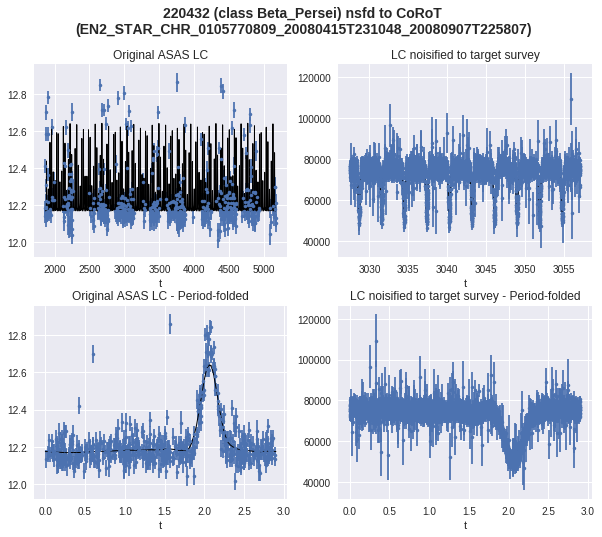

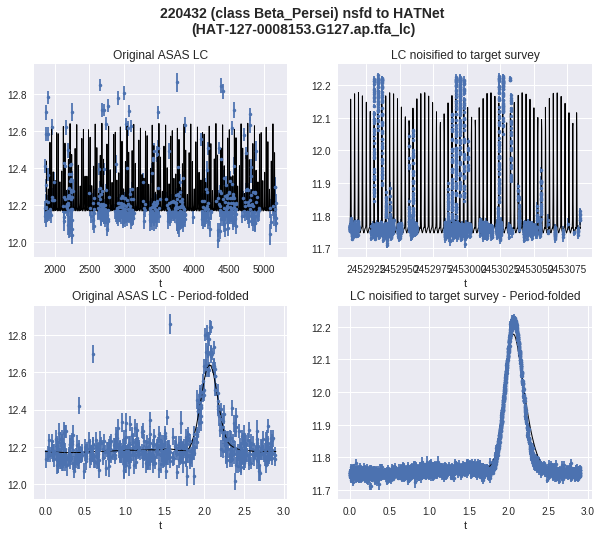

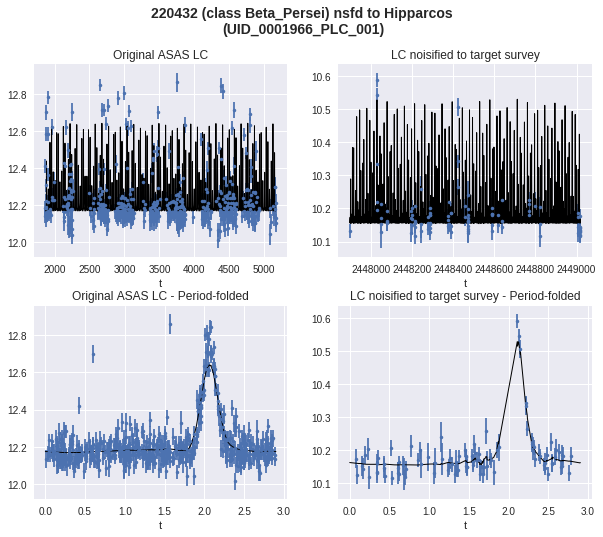

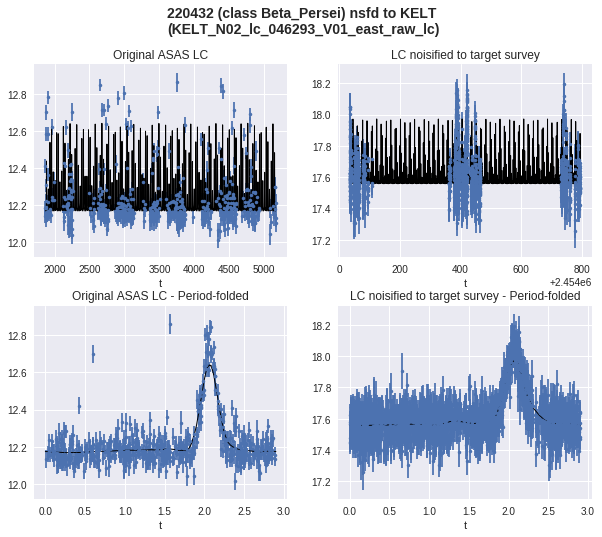

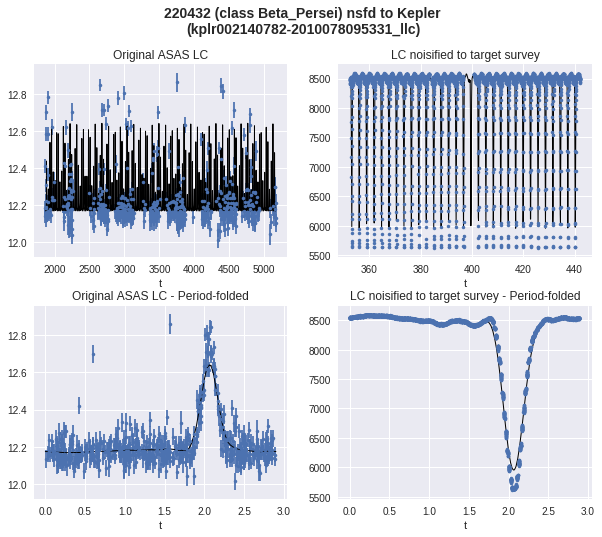

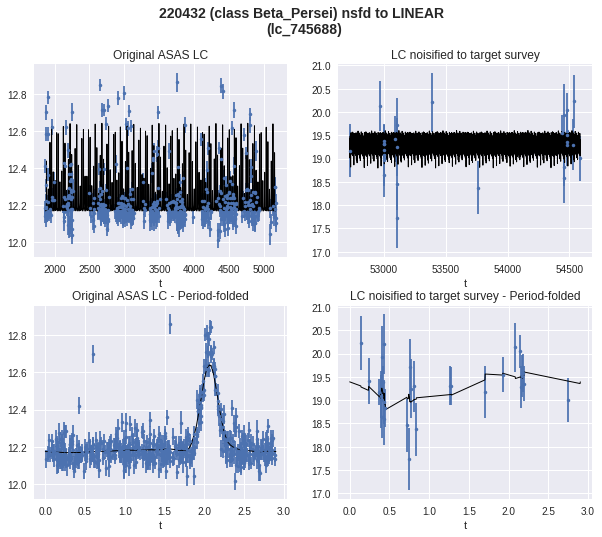

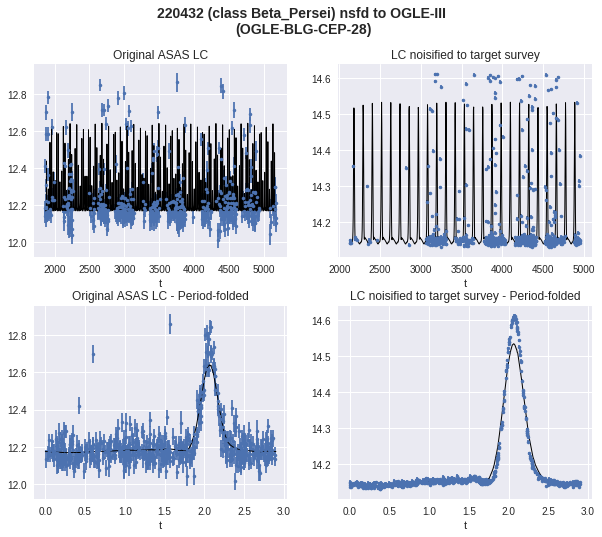

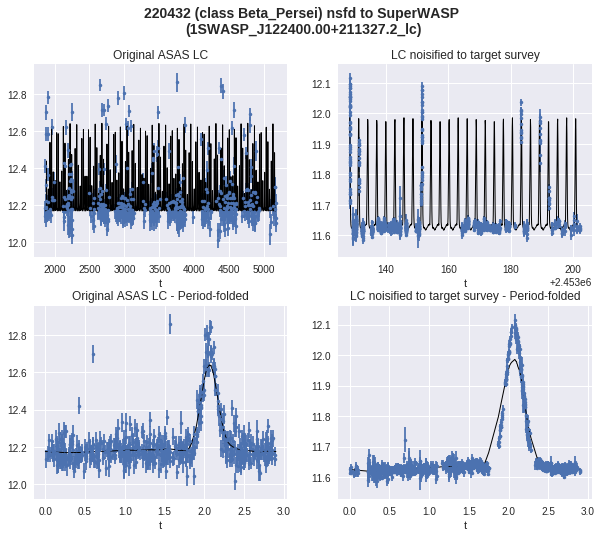

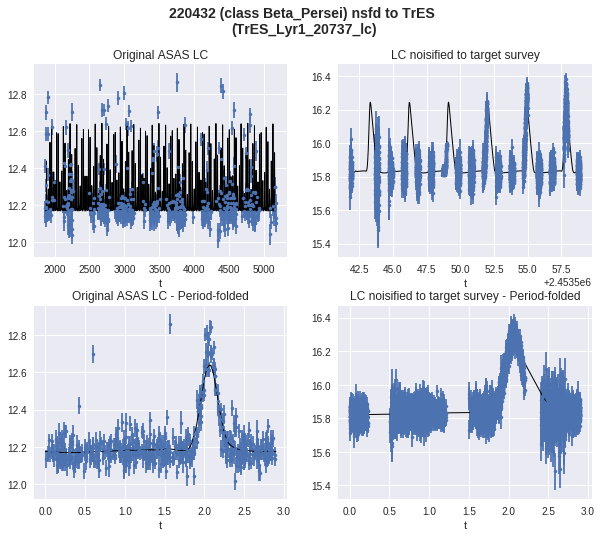

In [12]:
# survey_to_noisified_fpaths = {}
# # Smooth, noisify, & save LCs
# for survey in survey_to_fpaths_dict:
#     start_time = time.time()
#     survey_to_noisified_fpaths[survey] = []

#     # Get representative LC from this survey
#     survey_df = survey_fs.where(survey_fs.target==survey, drop=True).to_dataframe().drop('target', 1)
#     # Use top 17 most-important features only for finding representative LC
#     survey_df = survey_df[['cad_probs_40', 'all_times_nhist_peak4_bin', 'cad_probs_500000', 'cad_probs_500',
#                            'all_times_nhist_peak_1_to_3', 'med_double_to_single_step', 'cad_probs_1000',
#                            'cad_probs_10000000', 'all_times_nhist_peak3_bin', 'cad_probs_100', 'cad_probs_5000000', 'cad_probs_1000000',
#                            'all_times_nhist_peak_2_to_4', 'avg_double_to_single_step',
#                            'all_times_nhist_peak_1_to_4', 'cad_probs_30', 'cad_probs_5000', 'n_epochs']]
#     mean = survey_df.mean()
#     tree = scipy.spatial.KDTree(survey_df.values)
#     idx_closest = tree.query(mean)[1]
#     prototype_fname = str(survey_fs.where(survey_fs.target==survey, drop=True).name[idx_closest].values)
#     prototype_fpaths = [e for e in survey_to_fpaths_dict[survey] if
#                         os.path.basename(e).startswith(prototype_fname)]
#     assert len(prototype_fpaths) == 1
#     prototype_fpath = prototype_fpaths[0]
#     print('\n\n', prototype_fpath)

#     # Create target directory if it doesn't exist
#     noisified_lcs_dir = 'data_no_dups_longer/noisified_{}_lcs'.format(survey)
#     if not os.path.exists(noisified_lcs_dir):
#         os.mkdir(noisified_lcs_dir)

#     # List of tuples to dump into headerfile
#     fnames_targets = []

#     seen_classes = defaultdict(int)

#     # Smooth labeled ASAS LCs
#     for idx, name in enumerate(asas_featureset.name.values):
#         period = 1./asas_featureset.freq1_freq.sel(name=name).values[0]
#         assert name in asas_ts_paths[idx]

#         # Load TS data
#         ts = cesium.time_series.from_netcdf(asas_ts_paths[idx])
#         t, f, e = ts.time, ts.measurement, ts.error

#         class_name = ts.target
#         seen_classes[class_name] += 1
#         plot_title = ('{} (class {}) nsfd to {} \n({})'.format(ts.name, class_name, survey, prototype_fname)
#                       if seen_classes[class_name] == 2 and class_name == 'Beta_Persei' else None)

#         if seen_classes[class_name] != 2 or class_name != 'Beta_Persei':
#             continue

#         # Noisify each labeled ASAS LC to match prototype LC of target survey
#         target_ts = cesium.time_series.from_netcdf(prototype_fpath)
#         target_t, target_f, target_e = target_ts.time, target_ts.measurement, target_ts.error
#         target_t, noisified_f, target_e = noisify_light_curve(t, f, e, period,
#                                                               target_t, target_f, target_e, plot_title)
#         #print('target_t head and tail:', target_t[:5], target_t[-5:])
#         # Create TimeSeries object and save as NetCDF
#         new_ts = cesium.time_series.TimeSeries(
#             t=target_t, m=noisified_f, e=target_e,
#             target=str(asas_featureset.target.sel(name=name).values),
#             name=name,
#             path='{}/{}_nsfd_to_{}'.format(
#                 noisified_lcs_dir, name, os.path.basename(prototype_fpath)))
#         # new_ts.to_netcdf()
#         fnames_targets.append([os.path.basename(new_ts.path.replace('.nc', '')),
#                                str(asas_featureset.target.sel(name=name).values)])
#         survey_to_noisified_fpaths[survey].append(os.path.abspath(new_ts.path))
#     # Write header file
#     # pd.DataFrame(fnames_targets).to_csv('data_no_dups_longer/{}_header.dat'.format(survey),
#     #                                     index=False, header=False)
#     # print('Noisified all ASAS LCs to prototype {} LC in {} minutes.\n\n'.format(survey, round((time.time() - start_time)/60., 2)))
# #     # Tar noisified LCs
# #     with tarfile.open('{}.tar.gz'.format(noisified_lcs_dir), 'w:gz') as tar:
# #         tar.add(noisified_lcs_dir, arcname=os.path.basename(noisified_lcs_dir))

# Plot noisified W_Ursae_Maj LCs



 /home/arien/projects/survey_classifier/data_no_dups/EN2_STAR_CHR_0105770809_20080415T231048_20080907T225807.nc
target_t head and tail: [ 3027.46560088  3027.47152684  3027.47745279] [ 3057.10873075  3057.11465671  3057.12058267]


 /home/arien/projects/survey_classifier/data_no_dups/kplr002140782-2010078095331_llc.nc
target_t head and tail: [ 352.39648356  352.43734962  352.45778264] [ 442.16217622  442.18261069  442.20304506]


 /home/arien/projects/survey_classifier/data_no_dups/1SWASP_J122400.00+211327.2_lc.nc
target_t head and tail: [ 2453128.383299  2453128.385602  2453128.387905] [ 2453202.387465  2453202.392211  2453202.396968]


 /home/arien/projects/survey_classifier/data_no_dups/OGLE-BLG-CEP-28.nc
target_t head and tail: [ 2127.55168  2130.57614  2133.58626] [ 4949.81568  4951.84066  4953.74517]


 /home/arien/projects/survey_classifier/data_no_dups/lc_745688.nc
target_t head and tail: [ 52722.2226388  52966.3578771  53002.3719415] [ 54526.265926   54537.2088874  54589.145

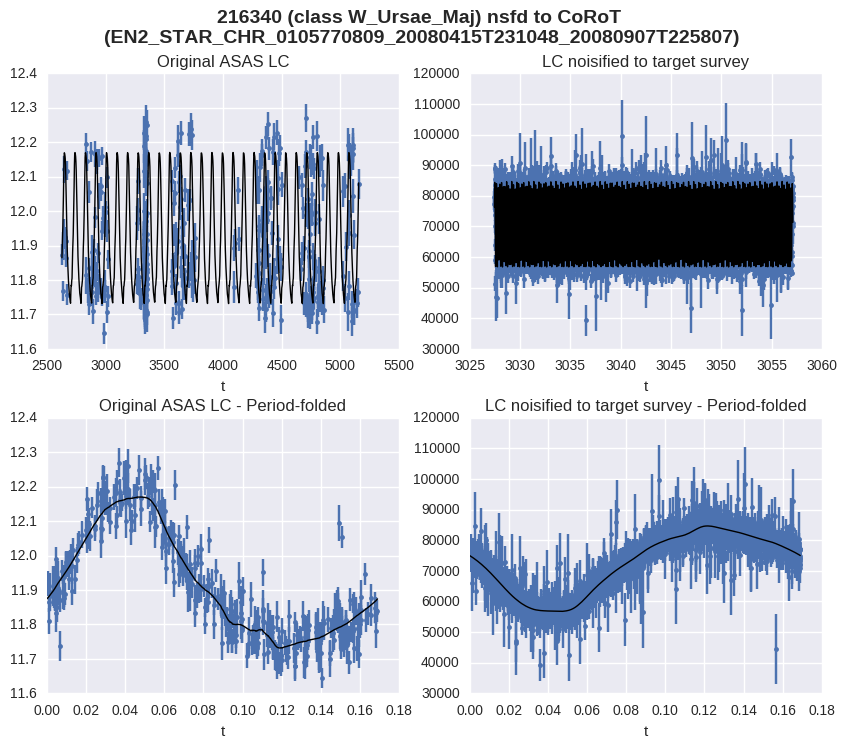

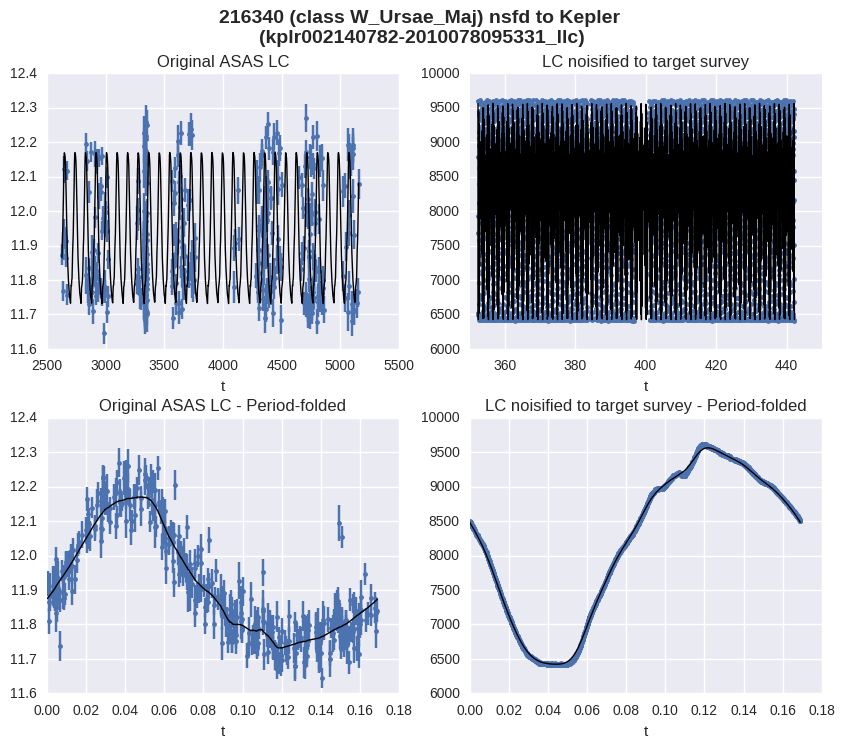

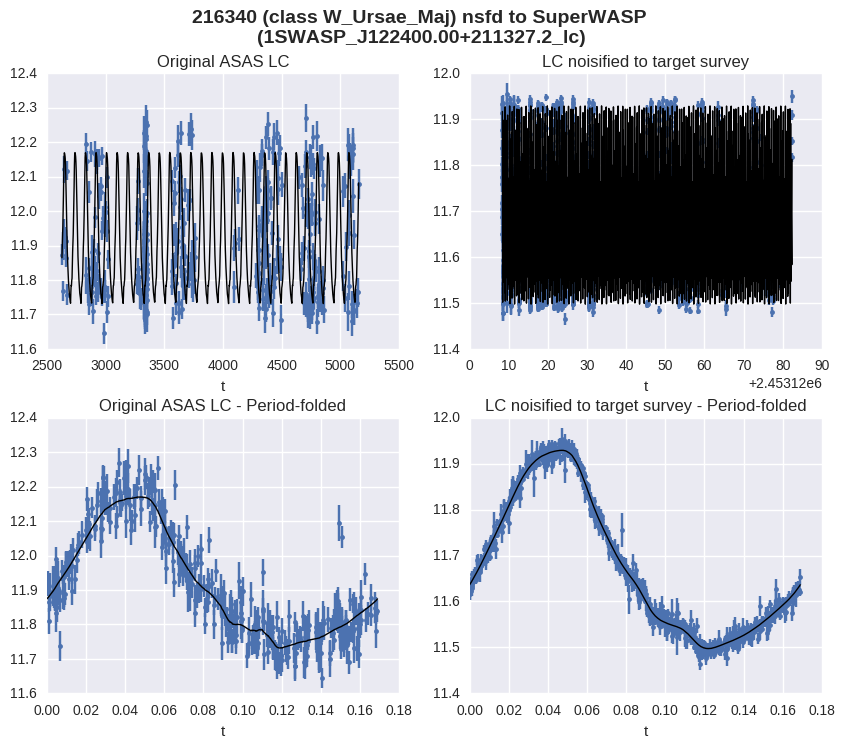

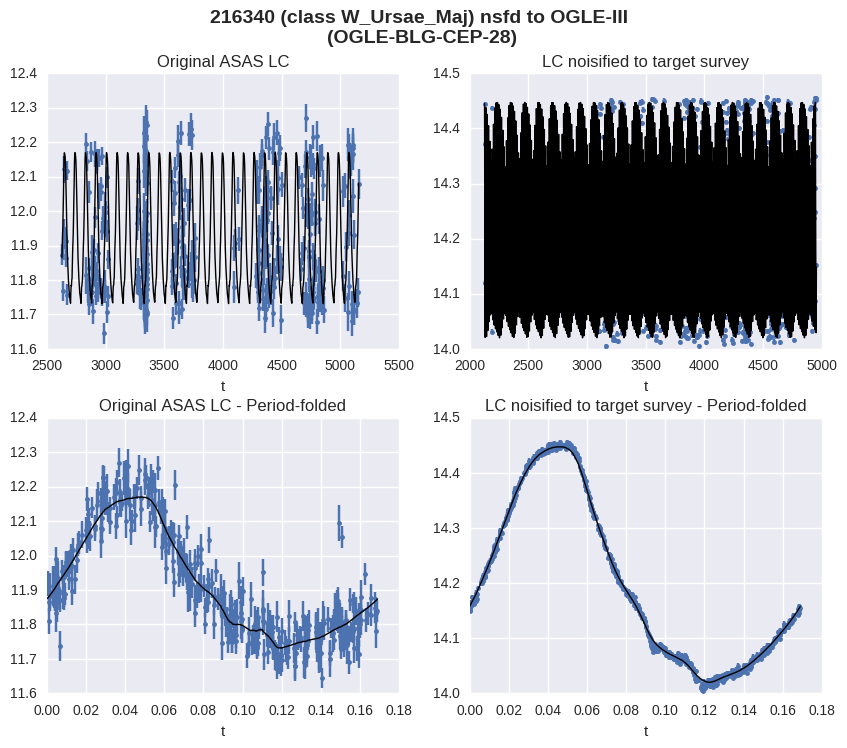

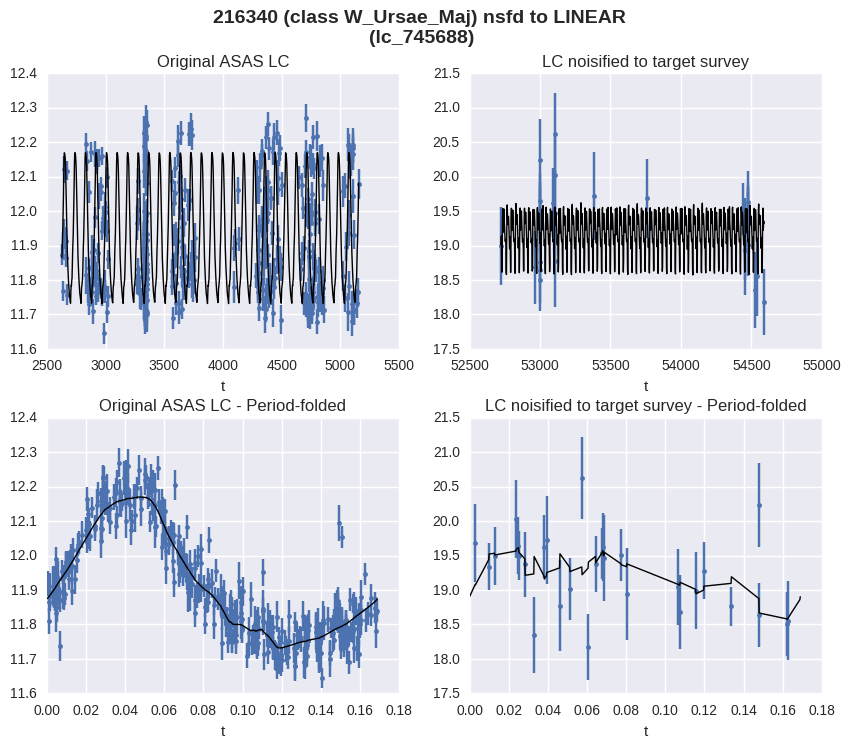

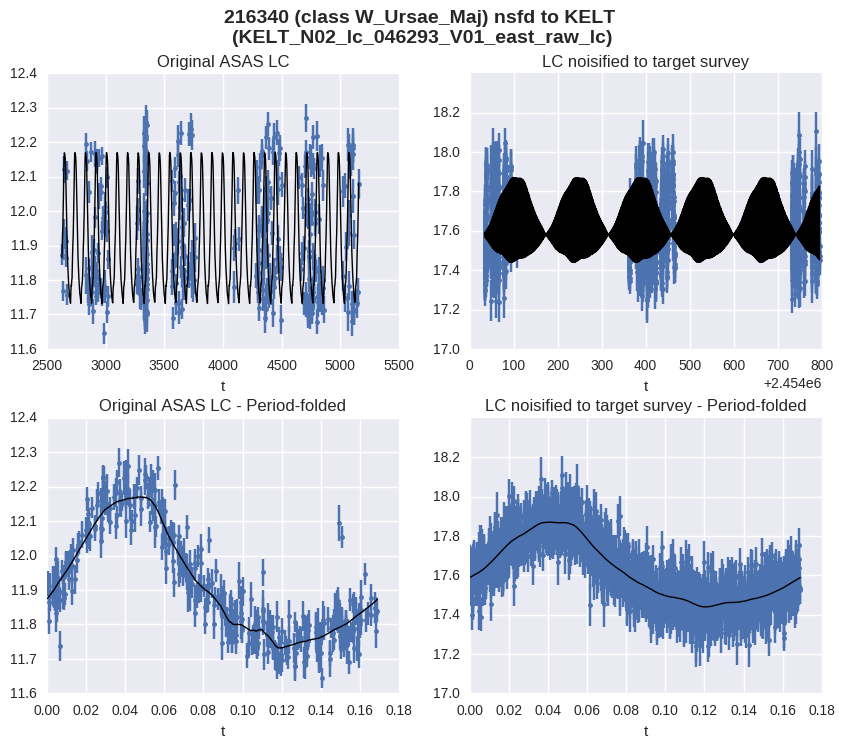

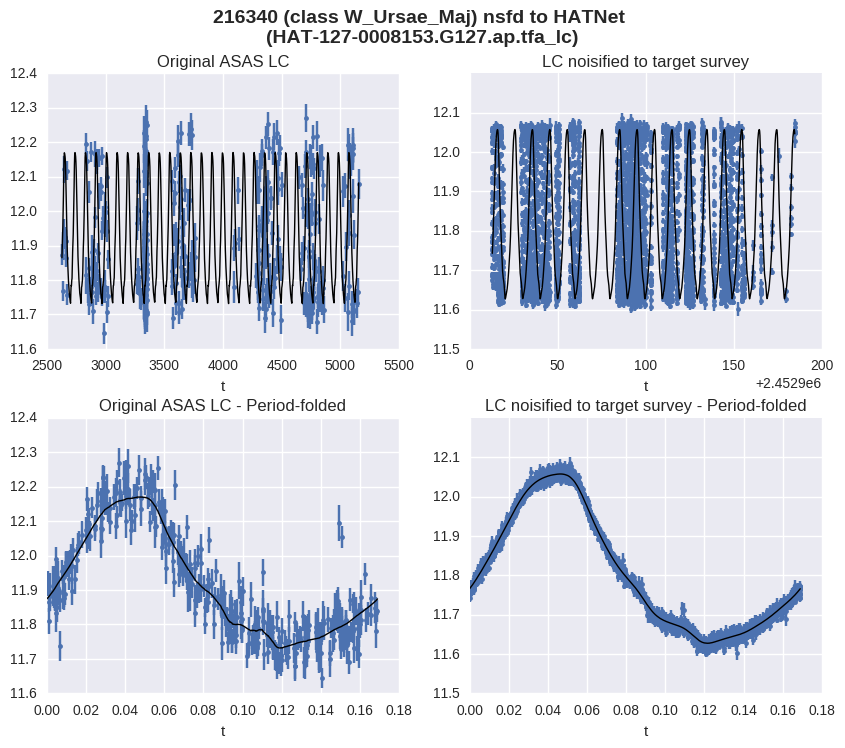

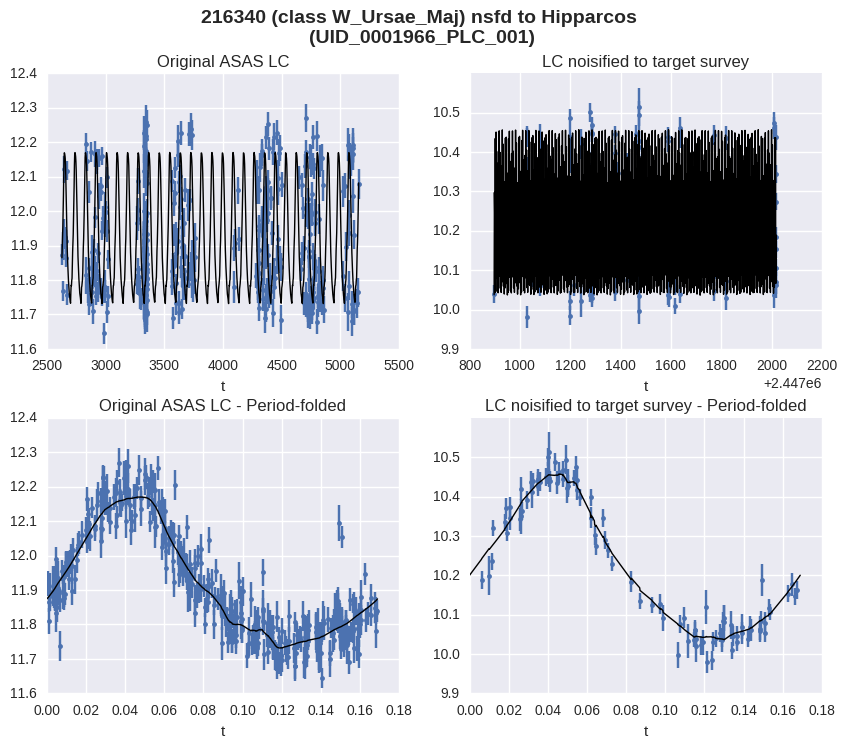

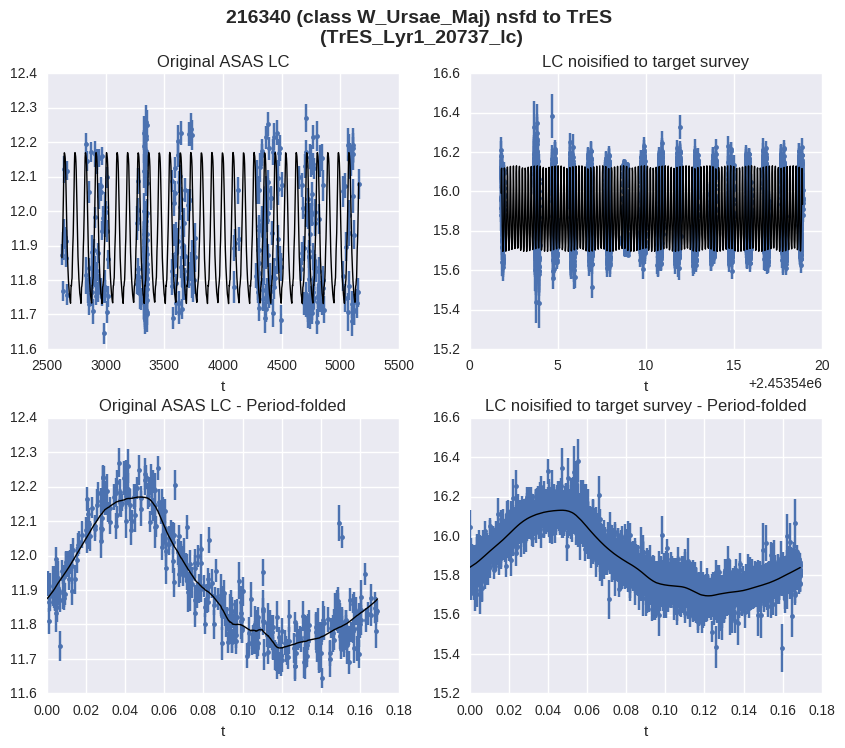

In [13]:
# survey_to_noisified_fpaths = {}
# # Smooth, noisify, & save LCs
# for survey in survey_to_fpaths_dict:
#     start_time = time.time()
#     survey_to_noisified_fpaths[survey] = []

#     # Get representative LC from this survey
#     survey_df = survey_fs.where(survey_fs.target==survey, drop=True).to_dataframe().drop('target', 1)
#     # Use top 17 most-important features only for finding representative LC
#     survey_df = survey_df[['cad_probs_40', 'all_times_nhist_peak4_bin', 'cad_probs_500000', 'cad_probs_500',
#                            'all_times_nhist_peak_1_to_3', 'med_double_to_single_step', 'cad_probs_1000',
#                            'cad_probs_10000000', 'all_times_nhist_peak3_bin', 'cad_probs_100', 'cad_probs_5000000', 'cad_probs_1000000',
#                            'all_times_nhist_peak_2_to_4', 'avg_double_to_single_step',
#                            'all_times_nhist_peak_1_to_4', 'cad_probs_30', 'cad_probs_5000', 'n_epochs']]
#     mean = survey_df.mean()
#     tree = scipy.spatial.KDTree(survey_df.values)
#     idx_closest = tree.query(mean)[1]
#     prototype_fname = str(survey_fs.where(survey_fs.target==survey, drop=True).name[idx_closest].values)
#     prototype_fpaths = [e for e in survey_to_fpaths_dict[survey] if
#                         os.path.basename(e).startswith(prototype_fname)]
#     assert len(prototype_fpaths) == 1
#     prototype_fpath = prototype_fpaths[0]
#     print('\n\n', prototype_fpath)

#     # Create target directory if it doesn't exist
#     noisified_lcs_dir = 'data_no_dups_longer/noisified_{}_lcs'.format(survey)
#     if not os.path.exists(noisified_lcs_dir):
#         os.mkdir(noisified_lcs_dir)

#     # List of tuples to dump into headerfile
#     fnames_targets = []

#     seen_classes = defaultdict(int)

#     # Smooth labeled ASAS LCs
#     for idx, name in enumerate(asas_featureset.name.values):
#         period = 1./asas_featureset.freq1_freq.sel(name=name).values[0]
#         assert name in asas_ts_paths[idx]

#         # Load TS data
#         ts = cesium.time_series.from_netcdf(asas_ts_paths[idx])
#         t, f, e = ts.time, ts.measurement, ts.error

#         class_name = ts.target
#         seen_classes[class_name] += 1
#         plot_title = ('{} (class {}) nsfd to {} \n({})'.format(ts.name, class_name, survey, prototype_fname)
#                       if seen_classes[class_name] == 2 and class_name == 'W_Ursae_Maj' else None)

#         if seen_classes[class_name] != 2 or class_name != 'W_Ursae_Maj':
#             continue

#         # Noisify each labeled ASAS LC to match prototype LC of target survey
#         target_ts = cesium.time_series.from_netcdf(prototype_fpath)
#         target_t, target_f, target_e = target_ts.time, target_ts.measurement, target_ts.error
#         target_t, noisified_f, target_e = noisify_light_curve(t, f, e, period,
#                                                               target_t, target_f, target_e, plot_title)
#         #print('target_t head and tail:', target_t[:5], target_t[-5:])
#         # Create TimeSeries object and save as NetCDF
#         new_ts = cesium.time_series.TimeSeries(
#             t=target_t, m=noisified_f, e=target_e,
#             target=str(asas_featureset.target.sel(name=name).values),
#             name=name,
#             path='{}/{}_nsfd_to_{}'.format(
#                 noisified_lcs_dir, name, os.path.basename(prototype_fpath)))
#         # new_ts.to_netcdf()
#         fnames_targets.append([os.path.basename(new_ts.path.replace('.nc', '')),
#                                str(asas_featureset.target.sel(name=name).values)])
#         survey_to_noisified_fpaths[survey].append(os.path.abspath(new_ts.path))
#     # Write header file
#     # pd.DataFrame(fnames_targets).to_csv('data_no_dups_longer/{}_header.dat'.format(survey),
#     #                                     index=False, header=False)
#     # print('Noisified all ASAS LCs to prototype {} LC in {} minutes.\n\n'.format(survey, round((time.time() - start_time)/60., 2)))
# #     # Tar noisified LCs
# #     with tarfile.open('{}.tar.gz'.format(noisified_lcs_dir), 'w:gz') as tar:
# #         tar.add(noisified_lcs_dir, arcname=os.path.basename(noisified_lcs_dir))

# Construct survey_to_noisified_fpaths dict if above cell not run

In [12]:
import glob

try:
    survey_to_noisified_fpaths
except NameError:
    survey_to_noisified_fpaths = {}

for survey in survey_to_fpaths_dict:
    if survey not in survey_to_noisified_fpaths:
        if survey == 'SuperWASP':
            data_dir = 'data_no_dups'
        else:
            data_dir = 'data_no_dups_longer'
        survey_to_noisified_fpaths[survey] = glob.glob('{}/noisified_{}_lcs/*'.format(data_dir, survey))

# Generate science features for noisified datasets

In [13]:
feats_to_use = GENERAL_FEATS + LOMB_SCARGLE_FEATS

for survey in survey_to_noisified_fpaths:
    if survey in ['CoRoT', 'HATNet', 'Hipparcos', 'KELT', 'Kepler', 'LINEAR', 'OGLE-III', 'SuperWASP']:
        continue
    print('Generating features for {} LCs...'.format(survey))
    start_time = time.time()
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        featureset = featurize_ts_files(survey_to_noisified_fpaths[survey], feats_to_use)
    featureset = featureset.impute()
    featureset.to_netcdf('data_no_dups_longer/noisified_{}_features.nc'.format(survey))
    print('Featurization for {} completed in {} minutes.'.format(survey, round((time.time() - start_time)/60., 2)))

Generating features for TrES LCs...
Featurization for TrES completed in 15.51 minutes.


/home/arien/anaconda3/envs/survey_app/lib/python3.6/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in less
  if not reflexive


# Build models

In [15]:
for survey in survey_to_noisified_fpaths:
    if survey in []:
        continue
    featureset = from_netcdf('data_no_dups_longer/noisified_{}_features.nc'.format(survey)).impute()
    print('\n\nBuilding model for {}...'.format(survey))
    start_time = time.time()
    model = build_model_from_featureset(
        featureset, model_type='RandomForestClassifier',
        model_parameters={'criterion': 'gini', 'n_jobs': -1},
        params_to_optimize={'n_estimators': [250, 500, 1000],
                            'max_features': [8, 10, 15, 18, 21],
                            'min_samples_leaf': [1, 2, 5]})
    print('{} model built in {} minutes.'.format(survey, round((time.time() - start_time)/60., 2)))
    print(model.best_params_)
    joblib.dump(model, 'data_no_dups_longer/noisified_{}_model_compressed.pkl'.format(survey), 9)



Building model for CoRoT...


/home/arien/anaconda3/envs/survey_app/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


CoRoT model built in 2.95 minutes.
{'max_features': 21, 'min_samples_leaf': 2, 'n_estimators': 1000}


Building model for HATNet...


/home/arien/anaconda3/envs/survey_app/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


HATNet model built in 3.0 minutes.
{'max_features': 18, 'min_samples_leaf': 2, 'n_estimators': 250}


Building model for Hipparcos...


/home/arien/anaconda3/envs/survey_app/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Hipparcos model built in 3.08 minutes.
{'max_features': 15, 'min_samples_leaf': 1, 'n_estimators': 500}


Building model for KELT...


/home/arien/anaconda3/envs/survey_app/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


KELT model built in 3.03 minutes.
{'max_features': 21, 'min_samples_leaf': 1, 'n_estimators': 500}


Building model for Kepler...


/home/arien/anaconda3/envs/survey_app/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Kepler model built in 2.93 minutes.
{'max_features': 21, 'min_samples_leaf': 1, 'n_estimators': 500}


Building model for LINEAR...


/home/arien/anaconda3/envs/survey_app/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


LINEAR model built in 3.08 minutes.
{'max_features': 21, 'min_samples_leaf': 1, 'n_estimators': 500}


Building model for OGLE-III...


/home/arien/anaconda3/envs/survey_app/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


OGLE-III model built in 2.99 minutes.
{'max_features': 18, 'min_samples_leaf': 1, 'n_estimators': 250}


Building model for SuperWASP...


/home/arien/anaconda3/envs/survey_app/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


SuperWASP model built in 3.08 minutes.
{'max_features': 21, 'min_samples_leaf': 1, 'n_estimators': 250}


Building model for TrES...


/home/arien/anaconda3/envs/survey_app/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


TrES model built in 3.14 minutes.
{'max_features': 21, 'min_samples_leaf': 5, 'n_estimators': 500}


# Featurize original ASAS LCs & build model

In [24]:
# Featurize
print('Generating features for {} LCs...'.format('ASAS'))
feats_to_use = cesium.features.GENERAL_FEATS + cesium.features.LOMB_SCARGLE_FEATS
start_time = time.time()
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    featureset = cesium.featurize.featurize_ts_files(asas_ts_paths, feats_to_use)
featureset = featureset.impute()
featureset.to_netcdf('data_no_dups_longer/noisified_{}_features.nc'.format('ASAS'))
print('Featurization for {} completed in {} minutes.'.format('ASAS', round((time.time() - start_time)/60., 2)))

# Build model
print('\n\nBuilding model for {}...'.format('ASAS'))
start_time = time.time()
model = cesium.build_model.build_model_from_featureset(
    featureset, model_type='RandomForestClassifier',
    model_parameters={'criterion': 'gini', 'n_jobs': -1},
    params_to_optimize={'n_estimators': [250, 500, 1000],
                        'max_features': [8, 10, 15, 18, 21],
                        'min_samples_leaf': [1, 2, 5]})
print('{} model built in {} minutes.'.format('ASAS', round((time.time() - start_time)/60., 2)))
print(model.best_params_)
joblib.dump(model, 'data_no_dups_longer/ASAS_model_compressed.pkl', 9)

Generating features for ASAS LCs...
Featurization for ASAS completed in 19.75 minutes.


Building model for ASAS...


/home/arien/anaconda3/envs/survey_app/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


ASAS model built in 5.26 minutes.
{'max_features': 21, 'min_samples_leaf': 1, 'n_estimators': 250}


['data_no_dups/ASAS_model_compressed.pkl']

# Compute training/test scores

In [17]:
# Load ASAS fs
asas_fs = from_netcdf('data_no_dups_longer/ASAS_features.nc')


# Drop all classes with fewer than 2 instances
MIN_EXAMPLES = 2
classes_to_drop = [label for label, count in pd.Series(asas_fs.target.values).value_counts().iteritems()
                   if count < MIN_EXAMPLES]
inds = [i for i, t in enumerate(asas_fs.target.values) if t not in classes_to_drop]
asas_fs = asas_fs.isel(name=inds)


# # Train/test split
train, test = train_test_split(np.arange(len(asas_fs.target)), train_size=0.8, test_size=0.2,
                               stratify=asas_fs.target.values, random_state=0)

# Build ASAS model
asas_model = build_model_from_featureset(
    asas_fs[train], model_type='RandomForestClassifier',
    model_parameters={'n_jobs': -1, 'n_estimators': 1000})

# Predict
pred = model_predictions(asas_fs, asas_model, return_probs=False)
print('*' * 20, 'ASAS train score:', np.mean(pred.prediction.values[train] == asas_fs.target.values[train]))
print('*' * 20, 'ASAS test score:', np.mean(pred.prediction.values[test] == asas_fs.target.values[test]))

pct_improvement_list = []

# Now for the noisified data
for survey in survey_to_fpaths_dict:
    if survey in []:
        continue

    # Load noisified featureset
    fset = from_netcdf('data_no_dups_longer/noisified_{}_features.nc'.format(survey)).impute()
    # Drop all classes with fewer than 2 instances
    MIN_EXAMPLES = 2
    classes_to_drop = [label for label, count in pd.Series(fset.target.values).value_counts().iteritems()
                       if count < MIN_EXAMPLES]
    inds = [i for i, t in enumerate(fset.target.values) if t not in classes_to_drop]
    fset = fset.isel(name=inds)
    
    # Train/test split
    train, test = train_test_split(np.arange(len(fset.target)), train_size=0.8, test_size=0.2,
                                   stratify=fset.target.values, random_state=0)

    # Build model
    print('\n\nBuilding model for {}...'.format(survey))
    start_time = time.time()
    model = build_model_from_featureset(
        fset[train], model_type='RandomForestClassifier',
        model_parameters={'n_jobs': -1, 'n_estimators': 1000})
    print('{} model built in {} minutes.'.format(survey, round((time.time() - start_time)/60., 2)))
    
    # Save model
    joblib.dump(model, 'data_no_dups_longer/noisified_{}_model_80t_compressed.pkl'.format(survey), 9)
    
    # Compute noisified model accuracy
    pred = model_predictions(fset, model, return_probs=False)
    train_score = np.mean(pred.prediction.values[train] == fset.target.values[train])
    test_score = np.mean(pred.prediction.values[test] == fset.target.values[test])
    print('*' * 20, 'noisified {} model train score:'.format(survey), train_score)
    print('*' * 20, 'noisified {} model test score:'.format(survey), test_score)
    
    # Compare with using regular ASAS model
    pred = model_predictions(fset, asas_model, return_probs=False)
    asas_model_train_score = np.mean(pred.prediction.values[train] == fset.target.values[train])
    asas_model_test_score = np.mean(pred.prediction.values[test] == fset.target.values[test])
    print('*' * 20, 'Noisified data with original ASAS model train score:'.format(survey), asas_model_train_score)
    print('*' * 20, 'Noisified data with original ASAS model test score:'.format(survey), asas_model_test_score)
    
    pct_improvement_list.append(((test_score - asas_model_test_score) / asas_model_test_score) * 100.0)
    print('*' * 25, round(pct_improvement_list[-1], 3), 
          'percent improvement over original ASAS model.', '\n\n')
    
    
print(np.mean(pct_improvement_list), "AVERAGE PERCENT IMPROVEMENT OVER NON-NOISIFIED MODEL (no dups - longer)")

******************** ASAS train score: 1.0
******************** ASAS test score: 0.746913580247


Building model for CoRoT...
CoRoT model built in 0.03 minutes.
******************** noisified CoRoT model train score: 1.0
******************** noisified CoRoT model test score: 0.574074074074
******************** Noisified data with original ASAS model train score: 0.113178294574
******************** Noisified data with original ASAS model test score: 0.111111111111
************************* 416.667 percent improvement over original ASAS model. 




Building model for HATNet...
HATNet model built in 0.03 minutes.
******************** noisified HATNet model train score: 1.0
******************** noisified HATNet model test score: 0.703703703704
******************** Noisified data with original ASAS model train score: 0.550387596899
******************** Noisified data with original ASAS model test score: 0.493827160494
************************* 42.5 percent improvement over original ASAS mod